In [1]:
 !pip install optiland
 import warnings
import numpy as np
from optiland import optic
import pandas as pd
import matplotlib as mpl #Removed extra space before 'import'
mpl.rcParams['font.family'] = 'DejaVu Sans'
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    accuracy_score,
    f1_score
)
from imblearn.over_sampling import SMOTE

from optiland.rays import RealRays

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 7.4 MB/s eta 0:00:00


In [2]:
class HeliarLens(optic.Optic):
    """Heliar Lens f/5

    Milton Laikin, Lens Design, 4th ed., CRC Press, 2007, p. 63
    """

    def __init__(self):
        super().__init__()

        # add surfaces
        self.add_surface(index=0, radius=np.inf, thickness=np.inf)
        self.add_surface(index=1, radius=4.2103, thickness=0.9004, material="N-SK16")
        self.add_surface(index=2, radius=-3.6208, thickness=0.2999, material="E-LLF6")
        self.add_surface(index=3, radius=29.1869, thickness=0.7587)
        self.add_surface(index=4, radius=-3.1715, thickness=0.2, material="E-LLF6")
        self.add_surface(index=5, radius=3.2083, thickness=0.1264)
        self.add_surface(index=6, radius=np.inf, thickness=0.2629, is_stop=True)
        self.add_surface(index=7, radius=43.0710, thickness=0.25, material="E-LLF6")
        self.add_surface(index=8, radius=2.4494, thickness=0.8308, material="N-SK16")
        self.add_surface(index=9, radius=-3.2576, thickness=8.5066)
        self.add_surface(index=10)

        # add aperture
        self.set_aperture(aperture_type="imageFNO", value=5)

        # add field
        self.set_field_type(field_type="angle")
        self.add_field(y=0)
        self.add_field(y=7)
        self.add_field(y=10)

        # add wavelength
        self.add_wavelength(value=0.48613270)
        self.add_wavelength(value=0.58756180, is_primary=True)
        self.add_wavelength(value=0.65627250)

In [3]:
lens = HeliarLens()

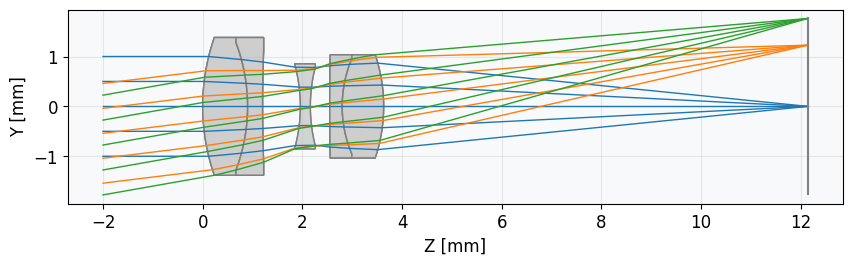

In [4]:
lens.draw(num_rays=5)

In [5]:
def get_random_rays(num_rays, seed=42):
    """Generate random rays."""
    np.random.seed(seed)

    # get random positions
    theta = np.random.uniform(0, 2 * np.pi, size=num_rays)
    r = 15.0 * np.sqrt(np.random.uniform(0, 1, size=num_rays))
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    z = np.full(num_rays, -10.0)  # starting ray point in object space

    # get random directions
    v = np.random.randn(3, num_rays)
    v /= np.linalg.norm(v, axis=0)
    v[2] = np.abs(v[2])  # Ensure positive z-direction
    L, M, N = v

    # define wavelength and intensity as constants
    intensity = np.ones(num_rays)
    wavelength = np.full(num_rays, 0.5876)

    return RealRays(x, y, z, L, M, N, intensity, wavelength)

In [6]:
def trace_random_rays(num_rays):
    # get random rays
    rays_in = get_random_rays(num_rays)

    # build input array
    inputs = np.column_stack([rays_in.x, rays_in.y, rays_in.L, rays_in.M, rays_in.N])

    # trace rays and return
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        rays_out = lens.surface_group.trace(rays_in)

    # build output array - simply checks if ray reached the image plane
    outputs = np.isfinite(rays_out.x)

    # merge into pandas dataframe
    data = pd.DataFrame(inputs, columns=['x', 'y', 'L', 'M', 'N'])
    data['success'] = outputs.astype(int)

    return data

In [7]:
num_rays = 10000

data = trace_random_rays(num_rays)

In [8]:
data.head()

,x,y,L,M,N,success
0,-6.464648,6.502116,-0.609402,-0.664849,0.431978,0
1,8.243106,-2.637505,0.782234,-0.588041,0.205713,0
2,-0.710737,-6.255356,0.706595,-0.642495,0.296520,0
3,-9.514255,-6.790726,-0.847069,0.529571,0.045032,0
4,5.765827,8.602074,0.886407,-0.303310,0.349694,0


In [9]:
print("Class Distribution:\n", data['success'].value_counts(normalize=True))

Class Distribution:
 success
0    0.9982
1    0.0018
Name: proportion, dtype: float64


We can view the distribution of the data columns using the `describe` method.

In [10]:
data.describe()

,x,y,L,M,N,success
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,-0.049790,0.120587,0.001506,-0.009693,0.495861,0.00180
std,7.553386,7.513981,0.574643,0.583829,0.288149,0.04239
min,-14.982737,-14.988932,-0.999432,-0.999912,0.000074,0.00000
25%,-6.154358,-5.885613,-0.496054,-0.525180,0.245264,0.00000
50%,-0.093724,0.190876,0.004508,-0.010757,0.494601,0.00000
75%,6.127142,6.210672,0.506225,0.503614,0.744554,0.00000
max,14.928971,14.989674,0.999844,0.999424,0.999999,1.00000


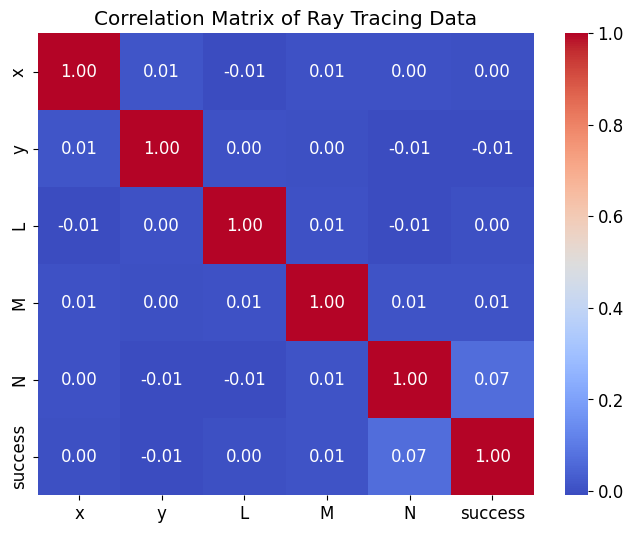

In [11]:
plt.figure(figsize=(8, 6))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Ray Tracing Data')
plt.show()

In [12]:
X = data.drop(columns=['success'])
y = data['success']

In [13]:
# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [14]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [15]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)


In [17]:
# Train Logistic Regression model
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

In [18]:
# Calculate and print the accuracy scores for both models
rf_accuracy = accuracy_score(y_test, y_pred_rf)
lr_accuracy = accuracy_score(y_test, y_pred_lr)

print(f"Random Forest Accuracy: {rf_accuracy}")
print(f"Logistic Regression Accuracy: {lr_accuracy}")


Random Forest Accuracy: 0.995
Logistic Regression Accuracy: 0.88


In [19]:

# Calculate and print other evaluation metrics for both models
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_lr))

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1996
           1       0.00      0.00      0.00         4

    accuracy                           0.99      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       1.00      0.99      1.00      2000

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.88      0.94      1996
           1       0.02      1.00      0.03         4

    accuracy                           0.88      2000
   macro avg       0.51      0.94      0.48      2000
weighted avg       1.00      0.88      0.93      2000



Random Forest Confusion Matrix:


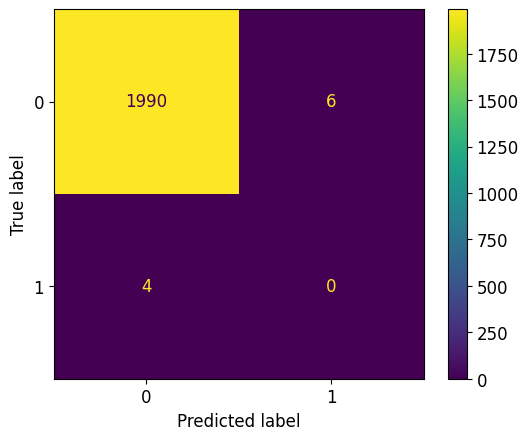

Logistic Regression Confusion Matrix:


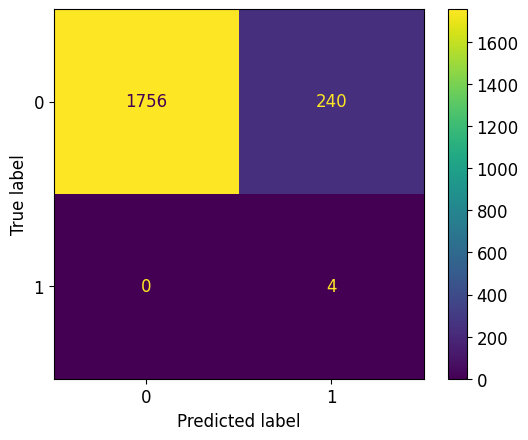

In [20]:

# Confusion matrices
print("Random Forest Confusion Matrix:")
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp_rf.plot()
plt.show()

print("Logistic Regression Confusion Matrix:")
cm_lr = confusion_matrix(y_test, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr)
disp_lr.plot()
plt.show()


Random Forest ROC AUC: 0.7352204408817635
Logistic Regression ROC AUC: 0.9495240480961924


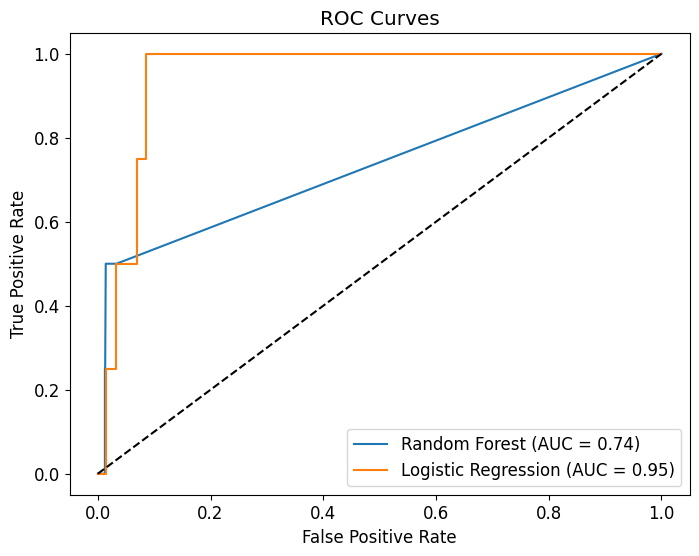

In [21]:
# ROC AUC scores
rf_roc_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])
lr_roc_auc = roc_auc_score(y_test, lr_model.predict_proba(X_test)[:, 1])

print(f"Random Forest ROC AUC: {rf_roc_auc}")
print(f"Logistic Regression ROC AUC: {lr_roc_auc}")

# ROC curves
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_model.predict_proba(X_test)[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_roc_auc:.2f})')
plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC = {lr_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()

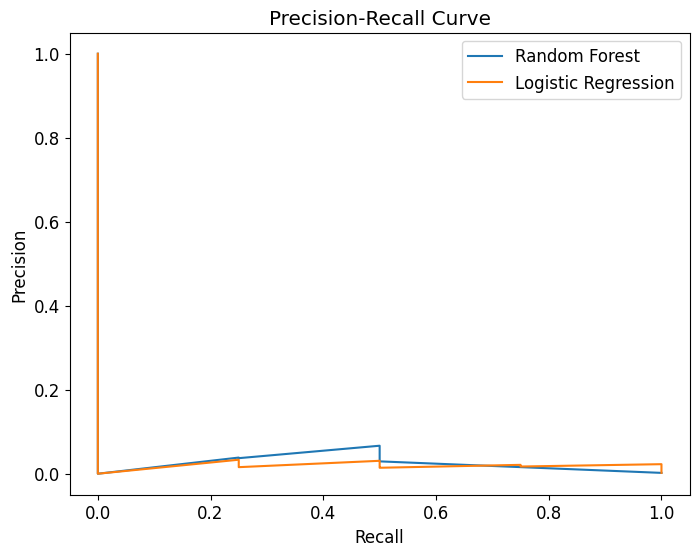

In [22]:
# Precision-recall curves
rf_precision, rf_recall, _ = precision_recall_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_model.predict_proba(X_test)[:, 1])


plt.figure(figsize=(8,6))
plt.plot(rf_recall, rf_precision, label='Random Forest')
plt.plot(lr_recall, lr_precision, label='Logistic Regression')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()